### 2023-06-05 cloud amount distributions

Look at distributions of fine resolution, coarsened fine, and nudged coarse cloud amount.

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import cftime
from dask.distributed import Client
from vcm.calc.histogram import histogram
from vcm.fv3.metadata import standardize_fv3_diagnostics

In [2]:
NUDGED_COARSE_PATH = 'gs://vcm-ml-experiments/cloud-ml/2023-07-03/cloud-ml-prognostic-run-nudge-to-fine-baseline/fv3gfs_run/state_after_timestep.zarr'
COARSENED_FINE_PATH = 'gs://vcm-ml-experiments/cloud-ml/2023-07-04/cloud-ml-training-data.zarr'
FINE_CLOUD_PATH = 'gs://vcm-ml-raw-flexible-retention/2023-06-29-PIRE-and-FV3GFS-like-C3072-ccnorm-true-simulation/C3072-restarts/2020080500/fv_tracer.res.zarr'
FINE_DELP_PATH = "gs://vcm-ml-raw-flexible-retention/2023-06-29-PIRE-and-FV3GFS-like-C3072-ccnorm-true-simulation/C3072-restarts/2020080500/fv_core.res.zarr"

In [3]:
SNAPSHOT = cftime.DatetimeJulian(2020, 8, 5, 0, 0, 0, 0)
FINE_SLICE = slice(None, None, 8) # 8 = downsample C3072 to C384 for speed reasons
OUTDIR = 'figures'
DEFAULT_COLOR_CYCLE = plt.rcParams['axes.prop_cycle'].by_key()['color']
COLOR_CYCLE = [DEFAULT_COLOR_CYCLE[i] for i in [5, 0, 2]]
LINEWIDTH_CYCLE = [1, 1.5, 1]
FONT_SIZE = 8

In [4]:
nudged_coarse_ds = xr.open_zarr(NUDGED_COARSE_PATH)
coarsened_fine_ds = xr.open_zarr(COARSENED_FINE_PATH)
fine_ds = xr.open_zarr(FINE_CLOUD_PATH)
fine_delp = xr.open_zarr(FINE_DELP_PATH).delp

In [5]:
Client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36155,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.39 GiB
Comm: tcp://127.0.0.1:36951,Total threads: 2
Dashboard: http://127.0.0.1:35419/status,Memory: 7.35 GiB
Nanny: tcp://127.0.0.1:35857,


In [6]:
def get_bin_centers(bin_edges, bin_widths):
    bin_centers = bin_edges + (bin_widths / 2)
    return bin_centers.assign_attrs({
        'long_name': bin_edges.name.replace('_', ' '),
        'units': '-'
    })

def column_mass_mean_cloud_fraction(cloud_fraction, delp, dim='z'):
    mass_averaged = cloud_fraction.weighted(delp).mean(dim=dim)
    return mass_averaged.assign_attrs(**cloud_fraction.attrs)

In [7]:
cloud_amount_bins = np.linspace(0, 1.0, 1001)
cell_cdfs = []
column_cdfs = []
for name, cloud_amount, delp in zip(
    ['native fine', 'coarsened fine', 'nudged coarse baseline'],
    [
        fine_ds.cld_amt,
        coarsened_fine_ds.cloud_amount.sel(time=SNAPSHOT),
        nudged_coarse_ds.cloud_amount.sel(time=SNAPSHOT),
    ],
    [
        fine_delp,
        coarsened_fine_ds.pressure_thickness_of_atmospheric_layer.sel(time=SNAPSHOT),
        nudged_coarse_ds.pressure_thickness_of_atmospheric_layer.sel(time=SNAPSHOT),
    ]
):
    print(name)
    # sometimes it's < 0 in the SHiELD data
    cloud_amount = cloud_amount.where(cloud_amount > 0., 0.)
    if name == 'native fine':
        # doesn't fit into memory and histogram is greedy
        cloud_amount = cloud_amount.sel(xaxis_1=FINE_SLICE, yaxis_1=FINE_SLICE)
        delp = delp.sel(xaxis_1=FINE_SLICE, yaxis_2=FINE_SLICE)
        column_cloud_amount = column_mass_mean_cloud_fraction(
            cloud_amount, delp, dim='zaxis_1'
        )
        cell_counts = None
        column_counts = None
        for tile in cloud_amount.tile:
            cloud_amount_tile = cloud_amount.sel(tile=tile)
            cloud_amount_tile.load()
            cell_counts_tile, _ = histogram(cloud_amount_tile, bins=cloud_amount_bins)
            if cell_counts is None:
                cell_counts = cell_counts_tile
            else:
                cell_counts += cell_counts_tile
            column_cloud_amount_tile = column_cloud_amount.sel(tile=tile)
            column_cloud_amount_tile.load()
            column_counts_tile, _ = histogram(column_cloud_amount_tile, bins=cloud_amount_bins)
            if column_counts is None:
                column_counts = column_counts_tile
            else:
                column_counts += column_counts_tile   
    else:
        cloud_amount.load()
        cell_counts, bin_widths = histogram(cloud_amount, bins=cloud_amount_bins)
        delp.load()
        column_cloud_amount = column_mass_mean_cloud_fraction(cloud_amount, delp)
        column_counts, _ = histogram(column_cloud_amount, bins=cloud_amount_bins)
    cell_cdf = cell_counts.cumsum() / cloud_amount.size
    cell_cdf = cell_cdf.rename({cell_cdf.dims[0]: 'cell_fractional_cloud_cover'})
    cell_cdfs.append(cell_cdf.expand_dims({'run': [name]}))
    column_cdf = column_counts.cumsum() / column_cloud_amount.size
    column_cdf = column_cdf.rename({column_cdf.dims[0]: 'column_average_fractional_cloud_cover'})
    column_cdfs.append(column_cdf.expand_dims({'run': [name]}))
cell_cloud_amount_cdfs = xr.concat(cell_cdfs, dim='run')
column_cloud_amount_cdfs = xr.concat(column_cdfs, dim='run')
cell_bin_widths = bin_widths.rename({bin_widths.dims[0]: 'cell_fractional_cloud_cover'})
column_bin_widths = bin_widths.rename({bin_widths.dims[0]: 'column_average_fractional_cloud_cover'})
cell_cloud_amount_cdfs = cell_cloud_amount_cdfs.assign_coords({
    'cell_fractional_cloud_cover': get_bin_centers(cell_cloud_amount_cdfs.cell_fractional_cloud_cover, cell_bin_widths)
})
column_cloud_amount_cdfs = column_cloud_amount_cdfs.assign_coords({
    'column_average_fractional_cloud_cover': get_bin_centers(column_cloud_amount_cdfs.column_average_fractional_cloud_cover, column_bin_widths)
})

native fine
coarsened fine
nudged coarse baseline


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


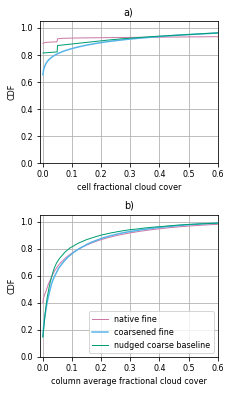

In [8]:
plt.rcParams.update({'font.size': FONT_SIZE})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=COLOR_CYCLE, linewidth=LINEWIDTH_CYCLE)


fig, axes = plt.subplots(2, 1)
ax0 = axes.flatten()[0]
cell_cloud_amount_cdfs.plot(hue='run', ax=ax0, add_legend=False)
ax0.grid()
ax0.set_xlim([-0.01, 0.6])
ax0.set_ylim([0, 1.05])
ax0.set_ylabel('CDF')
ax0.set_xlabel('cell fractional cloud cover')
ax0.set_title('a)')
ax1 = axes.flatten()[1]
h = column_cloud_amount_cdfs.plot(hue='run', ax=ax1, add_legend=False)
ax1.grid()
ax1.set_ylabel('CDF')
ax1.set_xlabel('column average fractional cloud cover')
ax1.set_xlim([-0.01, 0.6])
ax1.set_ylim([0, 1.05])
ax1.set_title('b)')
ax1.legend(h, column_cloud_amount_cdfs.run.values)
fig.set_size_inches([3.25, 5.5])
fig.tight_layout()
fig.savefig(f"./{OUTDIR}/fractional_cloud_cover_distributions.eps", bbox_inches='tight')